In [41]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import shutil

Compute all the bozorth3 comparisons (all vs. all): bozorth out/img1.xyt out/img2.xyt.

In [14]:
folder = "/Users/hugotrebert/Documents/Lju/ImageBasedBiometry_63554/LAB1/DB1_B/minutiae"
files = sorted([f for f in os.listdir(folder) if f.endswith(".xyt")])

genuine_scores = []
impostor_scores = []

def get_id(filename):
    return filename.split('_')[0]

for i in range(len(files)) :
    for j in range (i + 1, len(files)) :
      file1 = os.path.join(folder, files[i])
      file2 = os.path.join(folder, files[j])

      result = subprocess.run (
        ["bozorth3", file1, file2],
        capture_output=True,
        text=True
      )

      score = result.stdout.strip()
      
      im1 = get_id(files[i])
      im2 = get_id(files[j])
      
      if im1 == im2 :
        genuine_scores.append(int(score))
      else :
        impostor_scores.append(int(score))

0.25 pts Plot bozorth3 values for impostors and genuines on one graph.

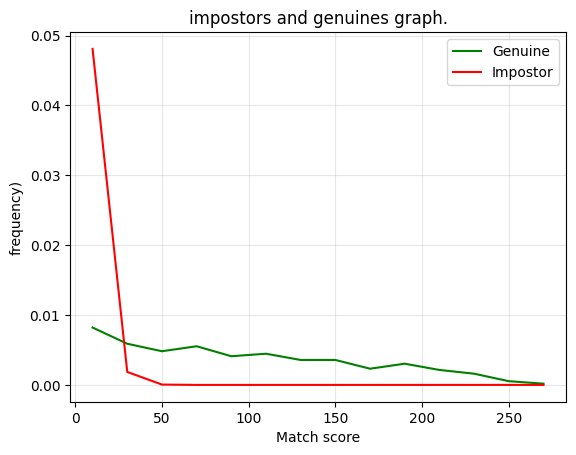

In [ ]:
min_score = min(min(genuine_scores), min(impostor_scores))
max_score = max(max(genuine_scores), max(impostor_scores))
bins = np.arange(min_score, max_score + 20, 20)

genuine_hist, _ = np.histogram(genuine_scores, bins=bins, density=True)
impostor_hist, _ = np.histogram(impostor_scores, bins=bins, density=True)

bin_centers = (bins[:-1] + bins[1:]) / 2

plt.plot(bin_centers, genuine_hist, label="Genuine", color="green")
plt.plot(bin_centers, impostor_hist, label="Impostor", color="red")

plt.xlabel("Match score")
plt.ylabel("frequency)")
plt.title("impostors and genuines graph")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

0.25 pts Plot the similarity matrix of all the compar- isons.

<Axes: >

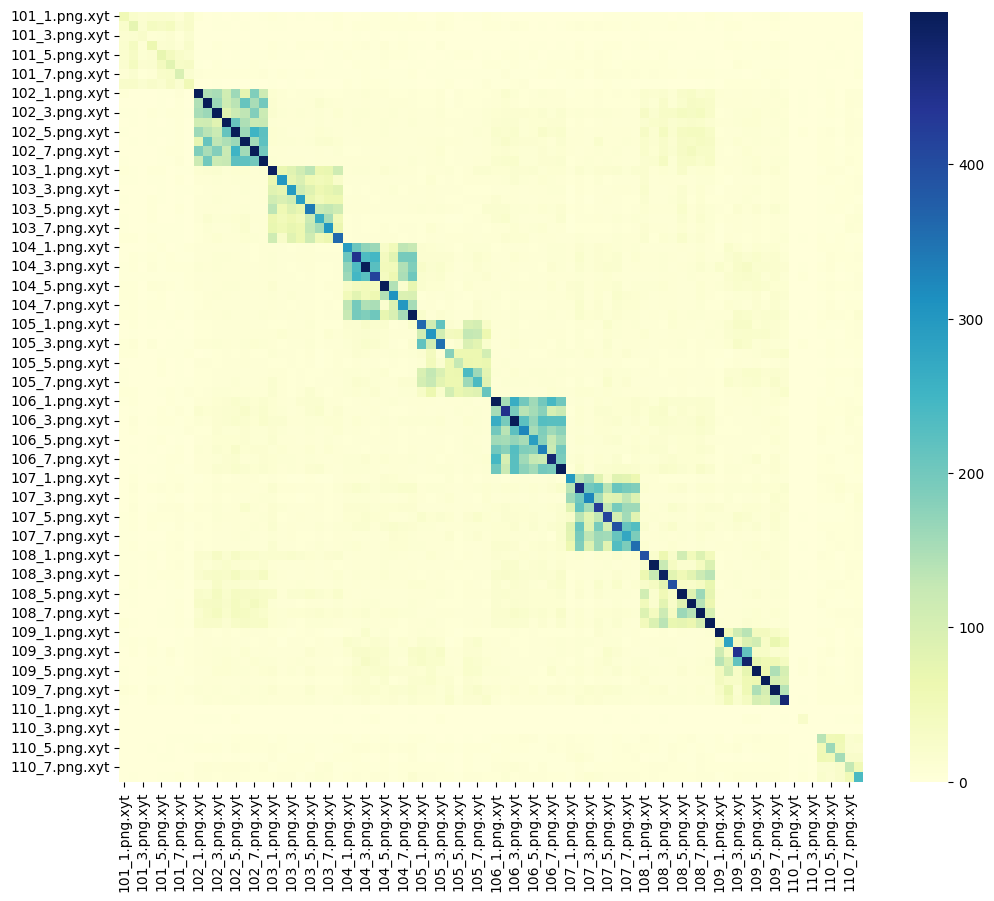

In [21]:
n = len(files)
scores_matrix = [[0]*n for _ in range(n)]

for i in range(len(files)) :
    for j in range (i, len(files)) :
      file1 = os.path.join(folder, files[i])
      file2 = os.path.join(folder, files[j])

      result = subprocess.run (
        ["bozorth3", file1, file2],
        capture_output=True,
        text=True
      )

      score = result.stdout.strip()

      scores_matrix[i][j] = int(score)
      scores_matrix[j][i] = int(score)


similarity_matrix = pd.DataFrame(scores_matrix, index = files, columns= files)

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(similarity_matrix, cmap='YlGnBu')

In [23]:
print(similarity_matrix.shape)

(80, 80)


0.25 pts Using nfiq (nfiq img.png), which gives you an estimate of fingerprint quality (1 is best, 5 is worst), plot the quality values of the fingerprints.

In [ ]:
folder_png = "/Users/hugotrebert/Documents/Lju/ImageBasedBiometry_63554/LAB1/DB1_B/png"
files_png = sorted([f for f in os.listdir(folder_png)])
id_list = [get_id(f) for f in files]
score_list = []


for i in range(n) :
  nfiq_result = subprocess.run (
    ["nfiq", os.path.join(folder_png, files_png[i])],
    capture_output=True,
    text=True,
  )

  nfiq_score = nfiq_result.stdout.strip()

  score_list.append(int(nfiq_score))

' quality_df = pd.DataFrame({\n  "id": id_list,\n  "nfiq": score_list,\n})\n\nprint(quality_df) '

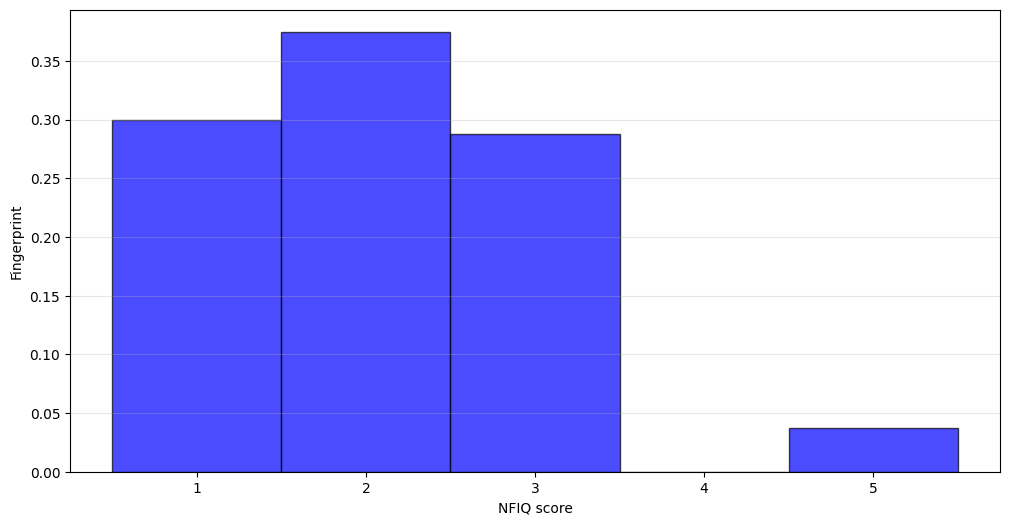

In [38]:
plt.figure(figsize=(12,6))
plt.hist(score_list, bins=np.arange(1,7)-0.5, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("NFIQ score")
plt.ylabel("Fingerprint")
plt.xticks(range(1,6))
plt.grid(axis = 'y', alpha=0.3)
plt.show()

1 pt Determine the best threshold for bozorth3 outputs (to distinguish same or different subjects) as accurately as possible. Use an approach of your choosing:
– You can select it based on observations from the genuine-impostor plot.
– You can compute FAR, FRR, and then the EER from them.
– You can empirically set the threshold by plotting the accuracy across different thresholds.
– Anyotherapproachofyourchoosing,justdescribe it clearly in the Methodology section of the report.

In [47]:
FRR_list = []
FAR_list = []
thresholds = []

for threshold in range(min_score, max_score + 1, 5) :
  TP = (sum(1 for score in genuine_scores if score >= threshold))
  FP = (sum(1 for score in impostor_scores if score >= threshold))
  TN = (sum(1 for score in impostor_scores if score < threshold))
  FN = (sum(1 for score in genuine_scores if score < threshold))
  
  FAR = FP / (FP + TN) if (FP + TN) > 0 else 0
  
  FRR = FN / (TP + FN) if (TP + FN) > 0 else 0
  
  FAR_list.append(FAR)
  FRR_list.append(FRR)
  thresholds.append(threshold)
  
diff = np.abs(np.array(FAR_list) - np.array(FRR_list))
eer_index = np.argmin(diff)

eer_threshold = thresholds[eer_index]
eer_value = (FAR_list[eer_index] + FRR_list[eer_index]) / 2

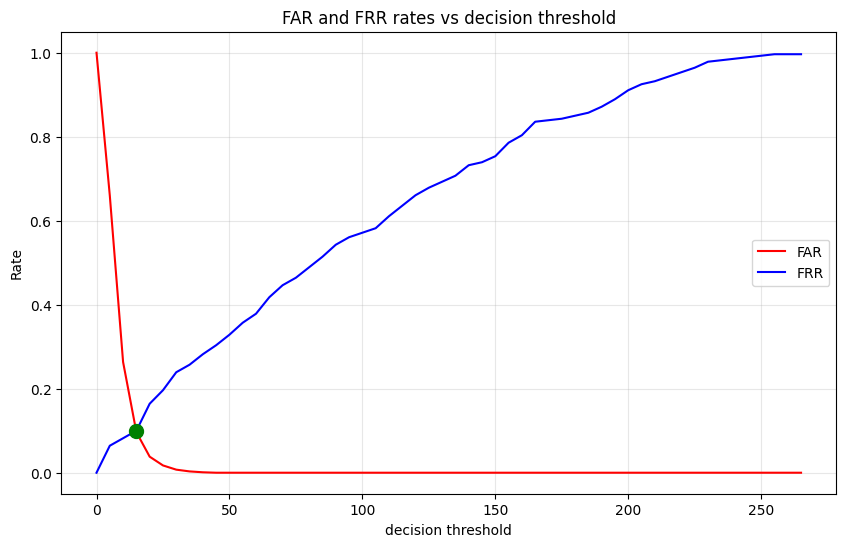

EER: 0.0983 at threshold 15


In [50]:
plt.figure(figsize=(10,6))

plt.plot(thresholds, FAR_list, label="FAR", color="red")
plt.plot(thresholds, FRR_list, label="FRR", color="blue")

plt.scatter(eer_threshold, eer_value, color='green', s=100, zorder=5)

plt.xlabel("decision threshold")
plt.ylabel("Rate")
plt.title("FAR and FRR rates vs decision threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"EER: {eer_value:.4f} at threshold {eer_threshold}")


1 pt Perform classification and report classification accuracy (the number of correctly classified pairs divided by the number of all comparisons). Do this by comparing all samples only once; no comparisons with themselves or repeated comparisons (i.e., do only A vs. B, and no B vs. A, A vs. A, B vs. B), and checking whether their class annotations match or not.

In [51]:
TP = (sum(1 for score in genuine_scores if score >= eer_threshold))
TN = (sum(1 for score in impostor_scores if score < eer_threshold))

TruePredict = TP + TN

accuracy = TruePredict / (len(genuine_scores) + len(impostor_scores))

print(f"Accuracy at EER threshold ({eer_threshold}): {accuracy:.4f}")


Accuracy at EER threshold (15): 0.9032


1 pt Modify the classification so that you first classify each fingerprint by its type (A = Arch, L = Left Loop,R = Right Loop,S = Scar,T = Tented Arch, W = Whorl), and then only match within this sub- group. To do this, call pcasys pcasys.prs.

In [29]:
folder_png = "/Users/hugotrebert/Documents/Lju/ImageBasedBiometry_63554/LAB1/DB1_B/png"
folder_wsq = "/Users/hugotrebert/Documents/Lju/ImageBasedBiometry_63554/LAB1/DB1_B/Wsq"

os.makedirs(folder_wsq, exist_ok=True)

for file in os.listdir(folder_png) :
    png_path = os.path.join(folder_png, file)
    base_name = os.path.splitext(file)[0]

    gray_path = os.path.join(folder_wsq, base_name + ".gray")
    wsq_path = os.path.join(folder_wsq, base_name + ".wsq")

    subprocess.run ([
      "magick", png_path,
      "-resize", "600x600!",
      "-depth", "8",
      "-type", "Grayscale",
      "-compress", "none",
      "-colorspace", "Gray",
      "-strip",
      gray_path
    ], check=True)

    subprocess.run ([
      "cwsq", "0.75", "wsq", gray_path,
      "-raw_in", "600,600,8,500"
    ], check=True)

    os.remove(gray_path)

In [26]:
folder = "/Users/hugotrebert/Documents/Lju/ImageBasedBiometry_63554/LAB1/DB1_B"
files_wsq = sorted([f for f in os.listdir(folder_wsq) if f.endswith(".wsq")])

with open(os.path.join(folder, "pcasys.txt"), "w") as f:
    for file in files_wsq :
        f.write(f"DB1_B/Wsq/{file} A\n")

In [40]:
groups = {"A": [], "L": [], "R": [], "S": [], "T": [], "W": []}
nb_line = 0

with open(os.path.join(folder, "pcasys_predictions"), "r") as f:
  for line in f:
    nb_line += 1
    if nb_line == 80:
      break
    line = line.strip()
    wsq_file = line.split(":")[0]
    fingerprint_type = line.split("hyp ")[1].split(",")[0].strip()
    groups[fingerprint_type].append(wsq_file)

print(groups)


{'A': [], 'L': ['101_1.wsq', '101_2.wsq', '101_5.wsq', '101_6.wsq', '101_7.wsq', '101_8.wsq', '102_1.wsq', '102_2.wsq', '102_3.wsq', '102_4.wsq', '102_5.wsq', '102_6.wsq', '102_7.wsq', '102_8.wsq', '103_1.wsq', '103_2.wsq', '103_3.wsq', '103_4.wsq', '103_5.wsq', '103_6.wsq', '103_7.wsq', '103_8.wsq', '104_2.wsq', '104_4.wsq', '104_6.wsq', '104_7.wsq', '105_4.wsq', '106_6.wsq', '106_7.wsq', '106_8.wsq', '107_2.wsq', '107_3.wsq', '107_7.wsq', '108_1.wsq', '108_3.wsq', '108_5.wsq', '108_7.wsq', '109_4.wsq', '110_1.wsq', '110_2.wsq', '110_3.wsq', '110_4.wsq', '110_5.wsq', '110_6.wsq', '110_7.wsq'], 'R': ['101_3.wsq', '101_4.wsq', '104_1.wsq', '104_3.wsq', '104_5.wsq', '104_8.wsq', '105_1.wsq', '105_2.wsq', '105_3.wsq', '105_5.wsq', '105_6.wsq', '105_7.wsq', '105_8.wsq', '106_5.wsq', '107_1.wsq', '107_4.wsq', '107_5.wsq', '107_6.wsq', '107_8.wsq', '109_1.wsq', '109_2.wsq', '109_3.wsq', '109_5.wsq', '109_6.wsq', '109_7.wsq', '109_8.wsq'], 'S': [], 'T': [], 'W': ['106_1.wsq', '106_2.wsq', '10

In [47]:
folder_minutiae = "/Users/hugotrebert/Documents/Lju/ImageBasedBiometry_63554/LAB1/DB1_B/minutiae"

for fingerprint_type in groups.keys() :
  type_folder = os.path.join(folder, fingerprint_type)
  os.makedirs(type_folder, exist_ok=True)
  
  for wsq_file in groups[fingerprint_type]:
    xyt_file = wsq_file.replace(".wsq", ".png.xyt")
    src_path = os.path.join(folder_minutiae, xyt_file)
    dst_path = os.path.join(type_folder, xyt_file)
    shutil.copyfile(src_path, dst_path)